In [94]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import pandas_ta as pta
from scipy import stats

In [95]:
ticks_df = pd.read_csv(".//input_files//ticker_list.csv")
#filter to only small and mid_cap stocks
ticks_df = ticks_df[ticks_df.cap_size != 'large']
print("stocks after filter = ", ticks_df.shape[0])

stocks after filter =  5992


In [96]:
run_state = False

start = (date.today()-timedelta(365))
end = date.today()

ticks_list = ticks_df.ticker.to_list()
ticks_list.append('^GSPC')

if run_state:
    stk_df = web.DataReader(ticks_list, 'yahoo', start, end)
    stk_df.to_csv(".//input_files//stockprice_data.csv")

    # snp500 = web.DataReader(['^GSPC'], 'yahoo', start, end)
    # snp500.to_csv(".//input_files//snp500.csv")
else:
    stk_df = pd.read_csv(".//input_files//stockprice_data.csv",header=[0,1], index_col=0)
    stk_df = stk_df.iloc[:-14,:]
    
stk_df.index = pd.to_datetime(stk_df.index)

stk_df = stk_df[['Adj Close']] #taking only the tail 64 since 64 trading days ~= 90 days
stk_df

Attributes Adj Close                                                      \
Symbols         SNGX   CORZ       OTEX       RADI        EXLS        OLO   
Date                                                                       
2021-10-15      1.10  10.68  48.896538  16.850000  124.150002  27.940001   
2021-10-18      1.06  10.68  48.984478  17.100000  125.830002  27.410000   
2021-10-19      1.06  10.60  49.082195  17.360001  124.129997  26.770000   
2021-10-20      1.05  10.98  49.258080  17.320000  123.699997  26.230000   
2021-10-21      1.03  11.00  49.316711  17.430000  122.839996  27.040001   
...              ...    ...        ...        ...         ...        ...   
2022-09-20      0.62   1.52  28.070000  12.240000  174.320007   8.000000   
2022-09-21      0.56   1.55  27.870001  12.350000  173.880005   8.080000   
2022-09-22      0.54   1.50  27.430000  12.110000  169.929993   7.700000   
2022-09-23      0.51   1.43  27.110001  11.540000  167.940002   7.930000   
2022-09-26      0.49   1.39  26.920000  10.920000  147.679993   7.720000   

Attributes                                          ...                        \
Symbols           EEFT       SPWR       OFED  LNDC  ...         KW       TARO   
Date                                                ...                         
2021-10-15  135.440002  27.540001  24.365740  9.81  ...  22.412367  63.830002   
2021-10-18  135.449997  27.440001  24.365740  9.58  ...  22.352970  62.279999   
2021-10-19  134.839996  29.570000  24.365740  9.54  ...  22.253975  62.439999   
2021-10-20  132.009995  28.799999  24.729261  9.51  ...  22.352970  62.410000   
2021-10-21  123.489998  29.760000  24.729261  9.68  ...  22.323271  63.889999   
...                ...        ...        ...   ...  ...        ...        ...   
2022-09-20   84.779999  26.469999  26.400000  9.18  ...  16.990000  30.370001   
2022-09-21   83.419998  26.480000  25.750000  9.16  ...  16.620001  29.440001   
2022-09-22   81.610001  25.180000  25.750000  9.00  ...  16.360001  31.360001   
2022-09-23   80.000000  24.690001  25.750000  8.78  ...  16.340000  30.930000   
2022-09-26   78.019997  24.100000  25.750000  8.57  ...  15.540000  30.730000   

Attributes                                                               
Symbols     GURE  MRAM  MVST        BST        KBR        ^GSPC EAI EMP  
Date                                                                     
2021-10-15  5.76  6.02  7.61  50.917503  42.316467  4471.370117 NaN NaN  
2021-10-18  5.95  6.20  8.23  51.261093  42.476078  4486.459961 NaN NaN  
2021-10-19  5.95  6.13  8.10  51.738297  42.715492  4519.629883 NaN NaN  
2021-10-20  5.96  6.07  8.10  51.738297  42.725468  4536.189941 NaN NaN  
2021-10-21  5.55  6.05  8.09  51.776474  43.224251  4549.779785 NaN NaN  
...          ...   ...   ...        ...        ...          ...  ..  ..  
2022-09-20  3.65  6.41  2.06  32.169998  47.540001  3855.929932 NaN NaN  
2022-09-21  3.63  6.36  2.11  31.870001  47.040001  3789.929932 NaN NaN  
2022-09-22  3.63  6.15  1.98  31.049999  45.610001  3757.989990 NaN NaN  
2022-09-23  3.55  6.14  1.90  30.270000  44.709999  3693.229980 NaN NaN  
2022-09-26  3.50  6.28  1.90  29.790001  43.980000  3655.040039 NaN NaN  

[238 rows x 5993 columns]

#### Condition 1 

In [97]:
snp_30daygain = ((stk_df.loc[stk_df.index[-1],('Adj Close','^GSPC')] - stk_df.loc[stk_df.index[-22],('Adj Close','^GSPC')])/stk_df.loc[stk_df.index[-22],('Adj Close','^GSPC')])

#condition1a = stocks that made 30% increase in 3 months
condition1a = ((stk_df.iloc[[-1],:] - stk_df.iloc[-22*3,:])/stk_df.iloc[-22*3,:]) >= 0.3 

#condition1b = stocks that gained more than snp500 in 30 days
condition1b = ((stk_df.iloc[[-1],:] - stk_df.iloc[-22,:])/stk_df.iloc[-22,:]) >= snp_30daygain #22 working days in a 30 calendar days

In [98]:
bool_mask = (condition1a + condition1b).values[0]
stk_df = stk_df.iloc[:,bool_mask] #stocks filtered to condition 1a&b

#### Condition 2

In [99]:
rsi65_df = stk_df[['Adj Close']].apply(lambda x: pta.rsi(x,length = 65))
rs65_df = rsi65_df.div(rsi65_df[('Adj Close','^GSPC')] , axis = 0)
#condition 2a = stocks that have a RS > 1.3 over 65 day period (3 calendar months)
condition2a = rs65_df.iloc[-1,:] >= 1.3

rsi260_df = stk_df[['Adj Close']].apply(lambda x: pta.rsi(x,length = 252-30))
rs260_df = rsi260_df.div(rsi260_df[('Adj Close','^GSPC')] , axis = 0)
# condition 2b = stocks that have a RS > 1.3 over 260 day period (1 calendar year)
condition2b = rs260_df.iloc[-1,:] >= 1.3

In [100]:
bool_mask = (condition2a + condition2b).values
stk_df = stk_df.iloc[:,bool_mask] #stocks filtered to condition 1a&b and 2a&b


#### Condition 3

In [101]:
ewm21_fd = stk_df.ewm(span=21, adjust=False).mean()

# condition 3 = 21 EMW > recent stock prices
condition3 = (stk_df.tail() >= ewm21_fd.tail()).all(axis='index') 

In [102]:
bool_mask = (condition3).values
stk_df = stk_df.iloc[:,bool_mask] 
ewm21_fd = ewm21_fd.iloc[:,bool_mask] 

In [103]:
stk_df.tail()

Attributes Adj Close                                                         \
Symbols         GDNR   VPCB   KAIR   DHAC  SHLX   ARBG   APAC    TMPM  IMRA   
Date                                                                          
2022-09-20      9.99  9.920  9.945  10.11  15.8  9.970  10.08  10.000  2.32   
2022-09-21      9.99  9.912  9.960  10.12  15.8  9.975  10.08   9.995  2.26   
2022-09-22      9.99  9.912  9.960  10.13  15.8  9.960  10.08   9.990  2.32   
2022-09-23      9.99  9.910  9.960  10.13  15.8  9.960  10.08   9.990  2.25   
2022-09-26      9.99  9.900  9.940  10.15  15.8  9.970  10.08   9.990  2.11   

Attributes         ...                                                   \
Symbols      AGBA  ...    AFAR   VCKA  RKTA   POW     EVE   CPAQ   ALTU   
Date               ...                                                    
2022-09-20  11.43  ...  10.030  10.35  9.90  9.95  10.105  10.05  10.03   
2022-09-21  11.45  ...  10.050  10.35  9.90  9.95  10.085  10.05  10.03   
2022-09-22  11.45  ...  10.050  10.35  9.90  9.95  10.060  10.05  10.02   
2022-09-23  11.44  ...  10.055  10.35  9.89  9.95  10.063  10.05  10.07   
2022-09-26  11.44  ...  10.060  10.35  9.89  9.95  10.080  10.07  10.04   

Attributes                           
Symbols      AHPA   PTIC       CALM  
Date                                 
2022-09-20  10.16  9.935  58.220001  
2022-09-21  10.16  9.930  60.869999  
2022-09-22  10.19  9.935  60.610001  
2022-09-23  10.19  9.950  60.570000  
2022-09-26  10.20  9.950  59.680000  

[5 rows x 301 columns]

#### Condition 4

In [104]:
#condition 4a = check if slope of 21 ewm > 0.15
slope21_df = stk_df[['Adj Close']].tail(21).apply(lambda x: stats.linregress(range(len(x)), x)[0])
condition4a = slope21_df >= 0.15

#condition 4b = check if slope of 14 ewm > 0.15
slope14_df = stk_df[['Adj Close']].tail(14).apply(lambda x: stats.linregress(range(len(x)), x)[0])
condition4b = slope14_df >= 0.15

#condition 4c = check if slope of 7 ewm > 0.15
slope7_df = stk_df[['Adj Close']].tail(7).apply(lambda x: stats.linregress(range(len(x)), x)[0])
condition4c = slope7_df >= 0.15

In [105]:
bool_mask = (condition4a*condition4b*condition4c).values
stk_df = stk_df.iloc[:,bool_mask] 

In [106]:
stk_df

Attributes  Adj Close                      
Symbols          XMTR       SAVA       CALM
Date                                       
2021-10-15  59.880001  49.689999  35.049999
2021-10-18  57.509998  50.160000  35.150002
2021-10-19  60.000000  47.500000  35.630001
2021-10-20  60.700001  46.389999  35.470001
2021-10-21  61.080002  46.560001  35.500000
...               ...        ...        ...
2022-09-20  60.080002  38.910000  58.220001
2022-09-21  62.209999  37.639999  60.869999
2022-09-22  61.150002  51.060001  60.610001
2022-09-23  60.049999  41.869999  60.570000
2022-09-26  58.230000  45.189999  59.680000

[238 rows x 3 columns]

In [113]:
collist = stk_df.columns
df_temp = pd.read_csv(".//input_files//stockprice_data.csv",header=[0,1], index_col=0)
df_temp = df_temp.iloc[-14:,:]
df_temp.index = pd.to_datetime(df_temp.index)
df_temp = df_temp[collist]

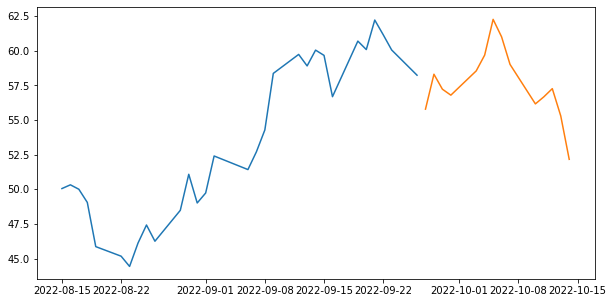

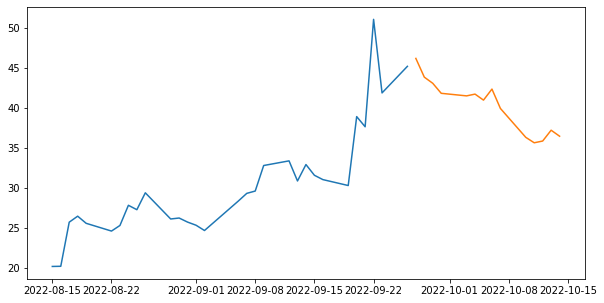

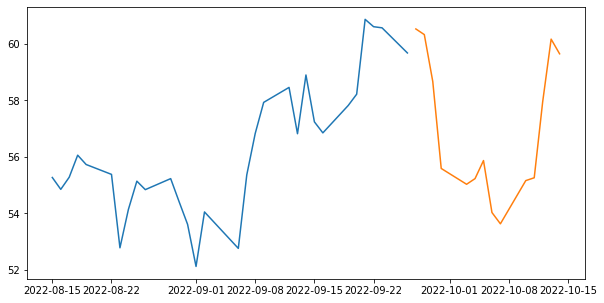

In [114]:
for i in df_temp.columns:
    plt.figure(figsize = (10,5))
    plt.plot(stk_df[i][-30:].index,stk_df[i][-30:].values)
    plt.plot(df_temp[i][-14:].index,df_temp[i][-14:].values)
    plt.show()